In [1]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
import glum

Plan: 
- Why Cox-PH-model is not a GLM.
- Cox-PH-model is a Poisson GLM with per-period-effects profiled out.
- Demonstrating the equivalence and simple Python function.
- (Maybe) allow option for ties, see 
    https://github.com/CamDavidsonPilon/lifelines/blob/b8f017446e81c8f2fec75970e3afbc130f7131ec/lifelines/fitters/coxph_fitter.py#L1620
    and
    https://myweb.uiowa.edu/pbreheny/7210/f15/notes/11-5.pdf
- Speed comparison.
- Extensions:
    - Stratification.
    - Less volatile baseline hazard.

TODO:
- (Why) do we need to split ties? And why does current method not work?
- Are numeric differences tenable?


First, we fit a standard Cox Proportional Hazards Model as becnhmark:

In [2]:
df = load_rossi()
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [3]:
cph = CoxPHFitter()
cph.fit(df, duration_col='week', event_col='arrest', formula="fin + age + race + wexp") #, ties="exact")

cph.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -664.22
         time fit was run = 2024-06-26 19:50:40 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.35      0.71      0.19           -0.72            0.02                0.49                1.03
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.26      1.30      0.31           -0.34            0.86                0.71                2.36
wexp      -0.36      0.70      0.20           -0.76            0.03                0.47                1.03

           cmp to     z    p  -log2(p)
covariate                             
fin          0.00 -1.83 0.07      3.89
age          0.00 -2.62 0.01      6.81
race         0.00  0.85 0.40      1.33
wexp         0.00 -1.79 0.07      3.78
---
Concordance = 0.62
Partial AIC = 1336.44
log-likelihood ratio test = 22.33 on 4 df
-log2(p) of ll-ratio test = 12.50

## Replicating the Cox-PH model with a GLM


See also `SurvSplit` in R

In [4]:
df[["week", "arrest"]]

,week,arrest
0,20,1
1,17,1
2,25,1
3,52,0
4,52,0
...,...,...
427,52,0
428,52,0
429,52,0
430,52,0


In [5]:
np.random.default_rng()

Generator(PCG64) at 0x28B227AE0

In [6]:
time = "week"
outcome = "arrest"

In [23]:
def survival_split(df, time, outcome, split_ties=False, seed=42):

    # table with unique event or censoring times
    df_times = df[[time]]
    if split_ties:
        # maybe TODO should use Efron's method instead (maybe)
        # TODO should add noise only if for non-censored times?
        df_times[time] = np.where(
            df[outcome],
            df_times[time] + np.random.default_rng(seed).uniform(low=-1e-2, high=1e-2, size=len(df)),
            df_times[time]
        )
    df_times = df_times.drop_duplicates().sort_values(time)

    # create table with one row per time and left row
    df['temp'] = 1
    # optional: add id
    df_times['temp'] = 1
    df_ = pd.merge(df, df_times, on="temp", how="left", suffixes=["_end", ""]).drop(columns='temp')
    df = df.drop(columns="temp")

    # remove rows after censoring or end time
    df_ = df_.loc[df_[time + "_end"] >= df_[time]].reset_index(drop=True)

    # add outcome
    df_[outcome] = np.where(
        df_[time + "_end"] == df_[time],
        df_[outcome],
        False if pd.api.types.is_bool_dtype(df_[time]) else 0
    )

    return df_.drop(columns=time + "_end")

In [24]:
df_split = survival_split(df, 'week', 'arrest')
df_split

,arrest,fin,age,race,wexp,mar,paro,prio,sample,week
0,0,0,27,1,0,0,1,3,train,1
1,0,0,27,1,0,0,1,3,train,2
2,0,0,27,1,0,0,1,3,train,3
3,0,0,27,1,0,0,1,3,train,4
4,0,0,27,1,0,0,1,3,train,5
...,...,...,...,...,...,...,...,...,...,...
18761,0,1,24,1,1,0,1,1,train,47
18762,0,1,24,1,1,0,1,1,train,48
18763,0,1,24,1,1,0,1,1,train,49
18764,0,1,24,1,1,0,1,1,train,50


In [25]:
model_glum = glum.GeneralizedLinearRegressor(family="poisson", formula="arrest ~ fin + age + race + wexp + C(week)", fit_intercept=False).fit(df_split)

In [26]:
model_glum.coef_table().reset_index().rename(columns={"index": "covariate"}).merge(cph.params_, on="covariate", how="left").head(8)

,covariate,coef_x,coef_y
0,fin,-0.348453,-0.348516
1,age,-0.057085,-0.057250
2,race,0.259051,0.259017
3,wexp,-0.362930,-0.362714
4,C(week)[1],-4.617920,NaN
5,C(week)[2],-4.613829,NaN
6,C(week)[3],-4.613104,NaN
7,C(week)[4],-4.610783,NaN


### What about standard errors?

In [27]:
cph.summary.reset_index()[["covariate", "coef", "se(coef)"]].merge(model_glum.coef_table(X=df_split)[["coef", "se"]], left_on="covariate", right_index=True).rename(columns={"coef_x": "coef_coxph", "coef_y": "coef_stack", "se(coef)": "se_coxph", "se": "se_stack"})

,covariate,coef_coxph,se_coxph,coef_stack,se_stack
0,fin,-0.348516,0.190464,-0.348453,0.191736
1,age,-0.057250,0.021882,-0.057085,0.025634
2,race,0.259017,0.305948,0.259051,0.303604
3,wexp,-0.362714,0.202104,-0.362930,0.213182


### What about speed?

In [14]:
%timeit cox_model = CoxPHFitter().fit(df, duration_col='week', event_col='arrest', formula="fin + age + race + wexp")

15.9 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit model_glum = glum.GeneralizedLinearRegressor(family="poisson", formula="arrest ~ fin + age + race + wexp + C(week)").fit(survival_split(df, 'week', 'arrest'))

10.4 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Beyond the Cox-PH model

Reformulating the Cox-PH model as a GLM clarifies several things:

- Is one fixed effect per event time really such a good idea?
- Why Poisson objective for binary outcomes if one could use logistic regression?

Evaluation idea:
- Train-test split 80-20.
- To allow for predicion with Cox-model, stratify over weeks.
- Train the stacked models,
  - once the Cox-equivalent one
  - once a model with spline for weeks an binomial objective.
- Evaluate outcomes: 
  - AUC per row.
  - Expected duration or similar.


In [28]:
rng = np.random.default_rng(42)
df["sample"] = rng.choice(["train", "test"], size=len(df), p=[0.8, 0.2])

In [46]:
def _get_train_test_split(x):
    out = ["train"]
    if len(x) > 1:
        out += list(rng.choice(["train", "test"], size=len(x) - 1, p=[0.8, 0.2]))
    return out

df["sample"] = df.groupby("week")["arrest"].transform(_get_train_test_split)

In [47]:
df["sample"].value_counts(normalize=True)

sample
train    0.805556
test     0.194444
Name: proportion, dtype: float64

Question: is it really necessary to have a stratified split, as long as we observe some until 52 weeks in both train and test?

-> For now, try without stratification:

In [48]:
df_split_train = survival_split(df.loc[df["sample"] == "train"], 'week', 'arrest')
df_split_train

/var/folders/r8/qzyl29vs7js42hpvkvd8zqb40000gn/T/ipykernel_13409/2933621241.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = 1


,arrest,fin,age,race,wexp,mar,paro,prio,sample,train_test_split,week
0,0,0,27,1,0,0,1,3,train,train,1
1,0,0,27,1,0,0,1,3,train,train,2
2,0,0,27,1,0,0,1,3,train,train,3
3,0,0,27,1,0,0,1,3,train,train,4
4,0,0,27,1,0,0,1,3,train,train,5
...,...,...,...,...,...,...,...,...,...,...,...
14812,0,1,31,0,1,0,1,3,train,test,47
14813,0,1,31,0,1,0,1,3,train,test,48
14814,0,1,31,0,1,0,1,3,train,test,49
14815,0,1,31,0,1,0,1,3,train,test,50


In [49]:
coxph_model = glum.GeneralizedLinearRegressor(family="poisson", formula="arrest ~ fin + age + race + wexp + C(week)", fit_intercept=False).fit(df_split_train)

In [61]:
logistic_model = glum.GeneralizedLinearRegressor(family="binomial", formula="arrest ~ fin + age + race + wexp + bs(week, 3)", fit_intercept=False).fit(df_split_train)

In [62]:
df_split_test = survival_split(df.loc[df["sample"] == "test"], 'week', 'arrest')
df_split_test

/var/folders/r8/qzyl29vs7js42hpvkvd8zqb40000gn/T/ipykernel_13409/2933621241.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = 1


,arrest,fin,age,race,wexp,mar,paro,prio,sample,train_test_split,week
0,0,0,22,1,0,0,0,6,test,train,9
1,0,0,22,1,0,0,0,6,test,train,18
2,0,0,22,1,0,0,0,6,test,train,25
3,0,0,22,1,0,0,0,6,test,train,26
4,0,0,22,1,0,0,0,6,test,train,30
...,...,...,...,...,...,...,...,...,...,...,...
862,0,1,24,1,1,0,1,1,test,train,44
863,0,1,24,1,1,0,1,1,test,train,45
864,0,1,24,1,1,0,1,1,test,train,49
865,0,1,24,1,1,0,1,1,test,train,50


In [63]:
df_split_test["p_coxph"] = coxph_model.predict(df_split_test)

In [64]:
df_split_test["p_logistic"] = logistic_model.predict(df_split_test)

<Axes: >

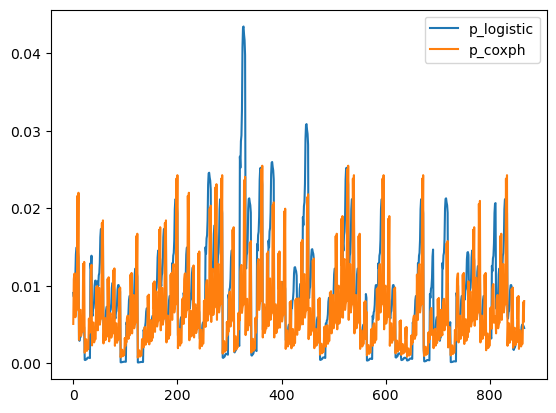

In [65]:
df_split_test[["p_logistic", "p_coxph"]].plot()

In [67]:
df_split_test

,arrest,fin,age,race,wexp,mar,paro,prio,sample,train_test_split,week,p_coxph,p_logistic
0,0,0,22,1,0,0,0,6,test,train,9,0.005071,0.009076
1,0,0,22,1,0,0,0,6,test,train,18,0.010844,0.008573
2,0,0,22,1,0,0,0,6,test,train,25,0.011511,0.009768
3,0,0,22,1,0,0,0,6,test,train,26,0.011599,0.010021
4,0,0,22,1,0,0,0,6,test,train,30,0.005937,0.011187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,0,1,24,1,1,0,1,1,test,train,44,0.002509,0.004969
863,0,1,24,1,1,0,1,1,test,train,45,0.002520,0.004985
864,0,1,24,1,1,0,1,1,test,train,49,0.007877,0.004859
865,0,1,24,1,1,0,1,1,test,train,50,0.005314,0.004776
